# Progetto Base

## Indice
- [Inizializzazione del notebook](#inizial)
    - [Installazioni](#installazioni)
    - [Imports](#imports)
    - [Utils](#utils)
- [Analisi dei dati](#an_dati)
    - [Importazione ed elaborazione dei dati](#dati)
    - [Statistiche Descrittive](#stat_desc)
    - [Analisi Correlazione](#analisi_corr)
      - [Correlazione Generale](#corr_generale)
      - [Correlazione average_rating, price](#corr_avg_rating_price)
      - [Correlazione rating_number, price](#corr_rating_n_price)
    - [Analisi Distribuzionale](#analisi_distr)
      - [Distribuzione dei rating](#distr_rating)
      - [Distribuzione rating medio in base a verified purchase](#distr_rating_medio_purchase)
      - [Recensioni con più helpful votes](#rec_helpful_votes)
      - [Rating nel tempo](#rating_nel_tempo)
      - [Analisi distribuzionale delle parole](#distr_parole)
- [Sistema di raccomandazione](#sis_di_raccomandazione)
    - [Configurazione ottimale KNN](#conf_ottimale_knn)
      - [Filling matrice di rating](#filling_knn)
    - [Configurazione ottimale Matrix Factorization](#conf_ottimale_matrix)
      - [Filling matrice di rating](#filling_matrix)
- [K-Means e Customer Segmentation](#k-means)
    - [Elbow Method con distorsione](#elbow)
    - [Configurazione ottima K-Means](#conf_ottima_k_means)


# Inizializzazione del notebook <a class="anchor"  id="inizial"></a>

## Installazioni <a class="anchor"  id="installazioni"></a>

In [1]:
!pip install datasets

In [2]:
!pip install nltk
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
!pip install wordcloud

## Imports <a class="anchor"  id="imports"></a>

In [5]:
from datasets import load_dataset

from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise import model_selection
from surprise import SVD

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, show
from bokeh.transform import cumsum
output_notebook()

import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn import preprocessing


import datetime

import matplotlib.pyplot as plt

import math

from PIL import Image

from wordcloud import WordCloud, STOPWORDS

Loading BokehJS ...

In [6]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [7]:
stop_words.update([',','.','!','?',';','-','...','[',']','{','}','(',')','&',':', '--','<','>','^','#','\\','/','\'','\"','br', '<br />', '\'s', '&#34', '34', 'n\'t', '\`', "''", '``'])

## Utils <a class="anchor"  id="utils"></a>

In [8]:
def text_processing(sentences, method="lemmatize"):
    tokenized_sentences = []
    for i, text in enumerate(sentences) :
        word_token = word_tokenize(text)
        tokens = []
        for word in word_token:
            if word.casefold() not in stop_words:
                if method == "lemmatize":
                    tokens.append(lemmatizer.lemmatize(word))
                else:
                    tokens.append(stemmer.stem(word))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

In [9]:
def cut_dataset(reviews, min_n_reviews_user, min_n_reviews_item):
    user_review_count = reviews.groupby("user_id").count()[["parent_asin"]].reset_index()
    print("numero di utenti: ", len(user_review_count[user_review_count["parent_asin"] > 0]))
    print("numero di utenti con un numero di recensioni > ", min_n_reviews_user, " : ", len(user_review_count[user_review_count["parent_asin"] > min_n_reviews_user]))
    users_id = user_review_count[user_review_count["parent_asin"] > min_n_reviews_user]["user_id"].unique().tolist()

    item_review_count = reviews.groupby("parent_asin").count()[["user_id"]].reset_index()
    print("numero di item: ", len(item_review_count[item_review_count["user_id"] > 0]))
    print("numero di item con un numero di recensioni > ", min_n_reviews_item, " : ", len(item_review_count[item_review_count["user_id"] > min_n_reviews_item]))
    items_id = item_review_count[item_review_count["user_id"] > min_n_reviews_item]["parent_asin"].tolist()

    reviews = reviews[reviews["user_id"].isin(users_id)].reset_index(drop=True)
    reviews = reviews[reviews["parent_asin"].isin(items_id)].reset_index(drop=True)

    # users_id e items_id vengono "risettati" in quanto può essere che un utente abbia dato due recensioni (e quindi venga incluso nella prima lista)
    # ma che le due recensioni appartengano a prodotti che hanno solo una recensione e quindi vengono eliminate le reviews -> quindi gli utenti (o gli item)
    # in questione non hanno più reviews (e il numero diminuisce)

    return reviews, reviews["user_id"].unique(), reviews["parent_asin"].unique()

In [10]:
def convert_timestamp(df):
    date = datetime.datetime.fromtimestamp(df["timestamp"]/1000).date()
    df["timestamp"] = str(date.year)
    return df

In [11]:
def add_title(df):
    df["text"] = df["title"]+ " " +df["text"]
    return df

In [12]:
def compute_reccomendation(users_id, items_id, n, algo):
    recc_dict = dict()

    for user_id in users_id:

        predicted_items = []
        for item_id in items_id:
            result = algo.predict(uid = user_id, iid = item_id)

            if result.r_ui is not None: #se l'utente ha già dato un rating, non voglio raccomandarlo, quindi mettiamo 0
                predicted_items.append(0)
            else:
                predicted_items.append(result.est)

        predicted_items = np.array(predicted_items)

        # gli elementi vengono ordinati in base allo score
        indexes_sorted = np.argsort(predicted_items)
        indexes_sorted = indexes_sorted[::-1] # inverto la lista perchè l'ordine è crescente

        #ordino le due liste allo stesso modo (predicted_items e scores)
        predicted_items = predicted_items[indexes_sorted]
        scores_list = items_id[indexes_sorted]

        recc_dict[str(user_id) + '-reccomended items'] = scores_list[:n]
        recc_dict[str(user_id) + '-scores'] = predicted_items[:n]

    return recc_dict

# Analisi dei dati <a class="anchor"  id="an_dati"></a>

## Importazione ed elaborazione dei dati <a class="anchor"  id="dati"></a>

In [13]:
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Software", trust_remote_code=True)
reviews = reviews["full"].to_pandas()
items_info = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Software", split="full", trust_remote_code=True)

Generating full split: 0 examples [00:00, ? examples/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [14]:
print(len(reviews))

reviews[["rating", "user_id", "parent_asin"]].head(5)

4880181


,rating,user_id,parent_asin
0,1.0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0BQSK9QCF
1,5.0,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,B00CTQ6SIG
2,5.0,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,B0066WJLU6
3,4.0,AH6CATODIVPVUOJEWHRSRCSKAOHA,B00KCYMAWK
4,4.0,AEINY4XOINMMJCK5GZ3M6MMHBN6A,B00P1RK566


Rimuoviamo gli utenti che hanno fatto poche recensioni e gli item con poche recensioni

In [15]:
reviews, users_id, items_id = cut_dataset(reviews, 30, 60)

numero di utenti:  2589466
numero di utenti con un numero di recensioni >  30  :  3027
numero di item:  89246
numero di item con un numero di recensioni >  60  :  7007


In [16]:
items_info = items_info.filter(lambda row: row["parent_asin"] in items_id)

Filter:   0%|          | 0/89251 [00:00<?, ? examples/s]

In [17]:
len(reviews)

111988

## Statistiche descrittive <a class="anchor"  id="stat_desc"></a>

In [18]:
print(reviews[['rating','timestamp','helpful_vote', 'verified_purchase']].describe()) #calcoliamo gli indici statistici base per descrivere il dataset

              rating     timestamp   helpful_vote
count  111988.000000  1.119880e+05  111988.000000
mean        3.907303  1.484798e+12       5.033629
std         1.389906  8.227908e+10      30.115302
min         1.000000  1.001017e+12       0.000000
25%         3.000000  1.420293e+12       0.000000
50%         5.000000  1.471359e+12       1.000000
75%         5.000000  1.552013e+12       3.000000
max         5.000000  1.681368e+12    6178.000000


## Analisi di correlazione <a class="anchor"  id="analisi_corr"></a>

### Correlazione generale <a class="anchor"  id="corr_generale"></a>

array([[<Axes: xlabel='rating', ylabel='rating'>,
        <Axes: xlabel='timestamp', ylabel='rating'>,
        <Axes: xlabel='helpful_vote', ylabel='rating'>],
       [<Axes: xlabel='rating', ylabel='timestamp'>,
        <Axes: xlabel='timestamp', ylabel='timestamp'>,
        <Axes: xlabel='helpful_vote', ylabel='timestamp'>],
       [<Axes: xlabel='rating', ylabel='helpful_vote'>,
        <Axes: xlabel='timestamp', ylabel='helpful_vote'>,
        <Axes: xlabel='helpful_vote', ylabel='helpful_vote'>]],
      dtype=object)

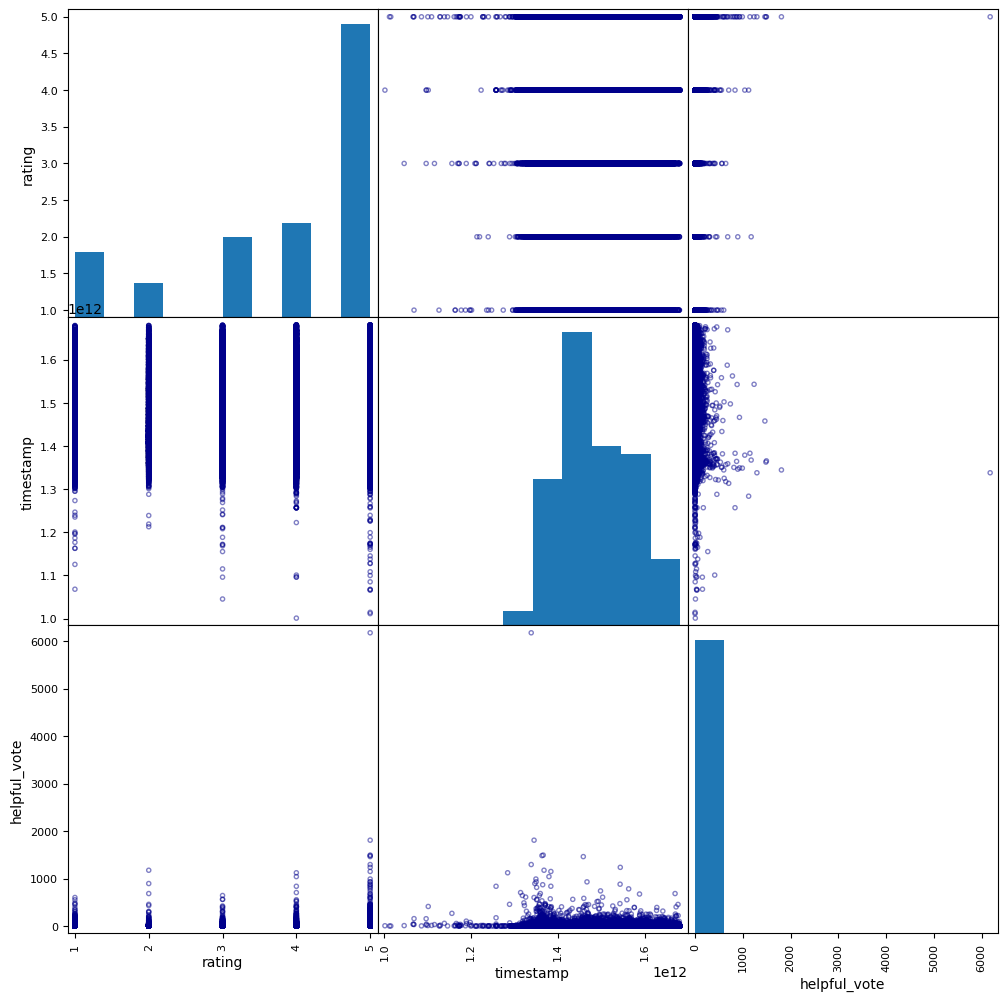

In [19]:
#plottiamo la scatter matrix
pd.plotting.scatter_matrix(reviews[['rating','timestamp','helpful_vote']], figsize=(12,12), c='none', edgecolor='darkblue')

### Correlazione average_rating, price <a class="anchor"  id="corr_avg_rating_price"></a>

In [20]:
avg_rating_price_matrix = [list(item) for item in zip(items_info["average_rating"], items_info["price"])] 

In [21]:
#remove None price rows
cleaned_avg_rating_price_matrix = []
for i in range(len(avg_rating_price_matrix)):
    if avg_rating_price_matrix[i][1] != 'None' and avg_rating_price_matrix[i][0] != None:
        cleaned_avg_rating_price_matrix.append([float(avg_rating_price_matrix[i][0]), float(avg_rating_price_matrix[i][1])])
cleaned_avg_rating_price_matrix[:5]

[[3.5, 0.0], [3.7, 0.0], [3.3, 0.0], [3.7, 0.0], [4.1, 3.99]]

<Axes: xlabel='average_rating', ylabel='price'>

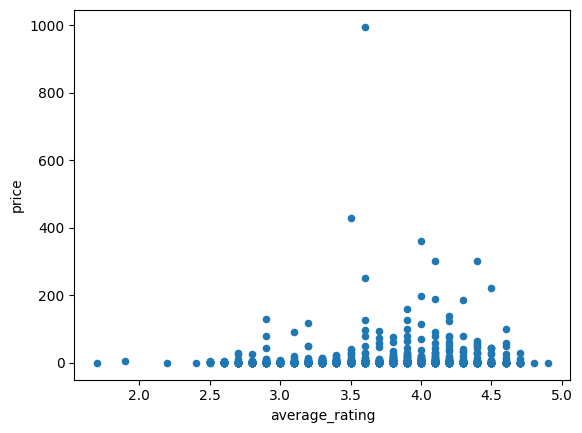

In [22]:
df = pd.DataFrame(cleaned_avg_rating_price_matrix, columns = ["average_rating", "price"])
df.plot(kind='scatter', x='average_rating', y='price')

### Correlazione rating_number, price <a class="anchor"  id="corr_rating_n_price"></a>

In [23]:
rating_n_price_matrix = [list(item) for item in zip(items_info["rating_number"], items_info["price"])] 

In [24]:
#remove None price rows
cleaned_rating_n_price_matrix = []
for i in range(len(rating_n_price_matrix)):
    if rating_n_price_matrix[i][1] != 'None' and rating_n_price_matrix[i][0] != None:
        cleaned_rating_n_price_matrix.append([float(rating_n_price_matrix[i][0]), float(rating_n_price_matrix[i][1])])
cleaned_rating_n_price_matrix[:5]

[[2835.0, 0.0], [106.0, 0.99], [2131.0, 0.0], [731.0, 0.0], [118.0, 0.0]]

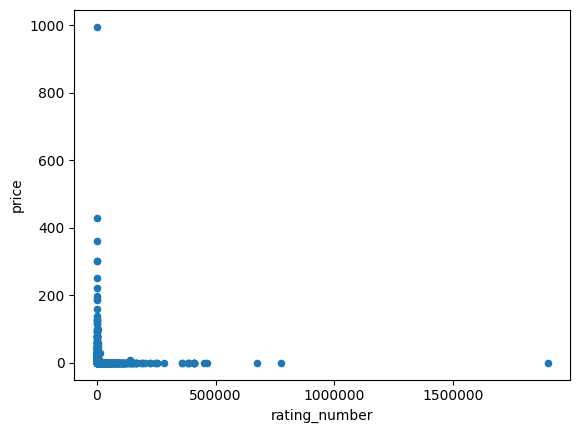

In [25]:
df = pd.DataFrame(cleaned_rating_n_price_matrix, columns = ["rating_number", "price"])

pl = df.plot(kind='scatter', x='rating_number', y='price', xticks = [0, 500000, 1000000, 1500000])
pl.ticklabel_format(axis="x", style="plain")

plt.show()

## Analisi distribuzionale <a class="anchor"  id="analisi_distr"></a>

### Distribuzione dei rating <a class="anchor"  id="distr_rating"></a>

In [26]:
ratings = ["1","2","3","4","5"]
counts = reviews.groupby("rating").count()[["parent_asin"]].values[:,0]

print(counts)
p = figure(x_range=ratings, height=350, title="Rating Counts")

p.vbar(x=ratings, top=counts, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

[12928  6835 15769 18614 57842]


In [27]:
show(p, notebook_handle=True) #plot della distribuzione dei ratings

In [28]:
ratings = ["1","2","3","4","5"]
counts = reviews.groupby("rating").count()[["parent_asin"]].values[:,0]

counts_dict = {"1":counts[0], "2":counts[1],"3":counts[2],"4":counts[3],"5":counts[4]}
counts_dict

{'1': 12928, '2': 6835, '3': 15769, '4': 18614, '5': 57842}

In [29]:
data = pd.Series(counts_dict).reset_index(name='value').rename(columns={'index': 'country'})
data['angle'] = data['value']/data['value'].sum() * 2* math.pi
data['color'] = ['#f54242', '#f59042', '#e9f542', '#8df542', '#00ff00']

p = figure(height=350, title="Rating counts", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='country', source=data)

GlyphRenderer(id='p1091', ...)

In [30]:
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None
show(p, notebook_handle=True) #plot della distribuzione dei ratings

### Distribuzione rating medio in base a verified purchase <a class="anchor"  id="distr_rating_medio_purchase"></a>

Viene esplorata la correlazione tra verified_purchase e rating per vedere se ad acquisti verificati corrispondono ratings più alti

In [31]:
labels = ["Not Verified Purchase", "Verified Purchase"]
counts = [reviews[reviews['verified_purchase'] == False]['rating'].mean(), reviews[reviews['verified_purchase'] == True]['rating'].mean()]
print(counts)
p = figure(x_range=labels, height=350, title="Rating Counts")

p.vbar(x=labels, top=counts, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

[3.4026162790697674, 3.913580804975952]


In [32]:
show(p, notebook_handle=True)

### Recensioni con più helpful votes <a class="anchor"  id="rec_helpful_votes"></a>

Analisi del sentiment delle recensioni correllata con il numero di helpful vote: l'idea è quella di vedere se esiste una correlazione tra le recensioni che vengono considerate più helpful da parte degli utenti e il sentiment a cui corrispondono

In [33]:
helpful_vote_n = reviews.groupby(["parent_asin","user_id","rating"])['helpful_vote'].sum()
helpful_vote_n = helpful_vote_n.sort_values()[::-1]
helpful_vote_n[:10]

parent_asin  user_id                       rating
B0086700CM   AHBZAI3V5AH4EGJQSCKPWREWPNAQ  5.0       6178
B008RA3X5E   AFOYRQEWLCJEFYV6I64L7S2WLETQ  5.0       1810
B00AB7HESI   AG7PCIWVZOWT5Q2WG7URPDKEZC2Q  5.0       1496
B00BQPEIT2   AFAHXM5DL4GKDNETZEW57LUIEWXQ  5.0       1485
B008XG1X18   AGI4OOLQVEGH3JBQCUET3OBTDLVA  5.0       1464
B007ZGO7EM   AEHOFUNZP6VT74RUDDCJ2VVIT56A  5.0       1297
B07FPS52BN   AF4FFRVBAKXVKJBFVKCMSTQYKGJQ  5.0       1238
B00AJAFNIA   AGYEEQLHIUB47CDI6X5M6VU4AT7Q  2.0       1177
B00FCYEZOQ   AE7KJNZJQ4BN3MCSW4JAFJGYVE6Q  5.0       1151
B003VNCROU   AE64UFB76MUZT2F2V7TCAWRO6PEA  4.0       1124
Name: helpful_vote, dtype: int64

In [34]:
x = reviews[reviews["parent_asin"] == "B0086700CM"]
y = x[x["user_id"] == "AHBZAI3V5AH4EGJQSCKPWREWPNAQ"]["text"]
print(str(y.iloc[0]))

This is a very addictive fun and fast paced game. I must confess that I had side loaded this game several months ago when it was available on Google play and I loved it.<br /><br />The game play is superb and has very good fast graphics on Kindle fire and hours of fun & excitement. Once you start playing this game I can assure you that you will never put it down - Beautifully done!<br /><br />While I was very happy to see that it was finally released for Amazon App store. Understandably I could not replace my existing Google play application or update it. I do not want to start all over again (I have scores in the millions with various characters unlocked with hours of play) so I prevented from the APP store replacing my game and kept the old version which I got free from Google play.<br /><br />This game has the best rating of any Android game ever. Glad it is officially available via Amazon APP store.<br />Thanks to the developer for making a fantastic free game.<br /><br />Download 

### Rating nel tempo <a class="anchor"  id="rating_nel_tempo"></a>

In [35]:
reviews = reviews.apply(convert_timestamp, axis = 1)
reviews[["timestamp", "rating"]]

,timestamp,rating
0,2022,4.0
1,2021,3.0
2,2021,5.0
3,2020,4.0
4,2018,4.0
...,...,...
111983,2014,5.0
111984,2014,5.0
111985,2014,3.0
111986,2014,5.0


In [36]:
reviews.groupby("timestamp")["rating"].mean()

timestamp
2001    4.000000
2002    5.000000
2003    3.800000
2004    4.166667
2005    3.800000
2006    3.571429
2007    3.400000
2008    3.583333
2009    3.444444
2010    3.833333
2011    3.632653
2012    3.682919
2013    3.841019
2014    3.827429
2015    3.867716
2016    3.956627
2017    4.015198
2018    3.873623
2019    3.966753
2020    3.989335
2021    3.946685
2022    3.942916
2023    4.352349
Name: rating, dtype: float64

In [37]:
labels = np.sort(reviews["timestamp"].unique())
counts = reviews.groupby("timestamp")["rating"].mean().to_list()

p = figure(x_range=labels, height=350, width = 1000, title="Rating Mean Over Time")

p.vbar(x=labels, top=counts, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

In [38]:
show(p, notebook_handle=True)

In [39]:
reviews.groupby("timestamp").count()["title"]

timestamp
2001        1
2002        2
2003        5
2004        6
2005        5
2006        7
2007       15
2008       12
2009       18
2010       24
2011      490
2012     3261
2013     8089
2014    15837
2015    18362
2016    14479
2017    10725
2018    10532
2019    12392
2020     8345
2021     5702
2022     3381
2023      298
Name: title, dtype: int64

In [40]:
labels = np.sort(reviews["timestamp"].unique())
counts = reviews.groupby("timestamp").count()["title"].to_list()

p = figure(x_range=labels, height=350, width = 1000, title="Number of Reviews Over Time")

p.vbar(x=labels, top=counts, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

In [41]:
show(p, notebook_handle=True)

### Analisi distribuzionale delle parole <a class="anchor"  id="distr_parole"></a>

In [42]:
merged_reviews = reviews.apply(add_title, axis = 1)["text"]
merged_reviews

0         reef rescue I like this game ok... but wish th...
1         discovery plus The app works... but... in gene...
2         dishanywhere app for firestick I downloaded th...
3         All in one mahjong Mom (80 years old) likes to...
4         Vegas slots As time blowers go, this is a casi...
                                ...                        
111983    I recommend this so much! I enjoy this game ve...
111984    Perfect app This game is very exciting! You ge...
111985    It's like being a vet You start off with to wo...
111986    Adorable little game This game is exactly like...
111987    It's alright In this game you build a very sim...
Name: text, Length: 111988, dtype: object

In [43]:
description_tokens = text_processing(merged_reviews)

In [44]:
token_list = []
for i in range(len(description_tokens)):
    description = description_tokens[i]
    for token in description:
        token_list.append(token)
token_list[:5]

['reef', 'rescue', 'like', 'game', 'ok']

In [45]:
word_counts = {}
for word in token_list:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

In [46]:
list(word_counts.values())[:5]

[4, 54, 20611, 71606, 4471]

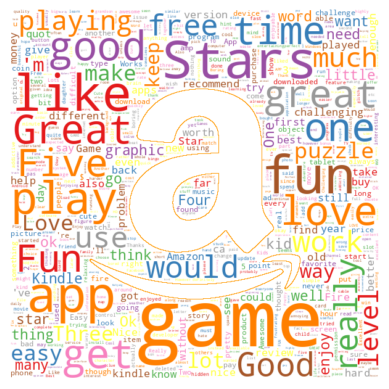

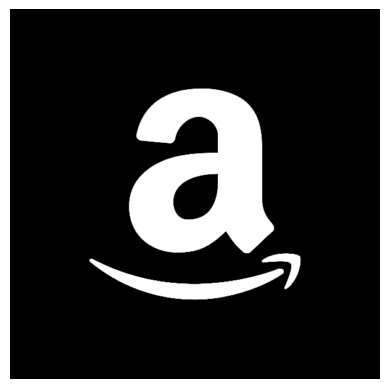

In [47]:
# read the mask image
amazon_mask = np.array(Image.open("/kaggle/input/amazon_logo.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=amazon_mask,
               stopwords=stopwords, contour_width=1, contour_color='#FF9900', colormap="Set1")

# generate word cloud
wc.generate_from_frequencies(word_counts)

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(amazon_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
#wc.to_file("/kaggle/working/cloud.png") to save the image

# Sistema di raccomandazione <a class="anchor"  id="sis_di_raccomandazione"></a>

In [49]:
# creazione del dataset surprise
reader = Reader(rating_scale=(1, 5))
dataset_surprise = Dataset.load_from_df(reviews[['user_id', 'parent_asin', 'rating']], reader)

### Configurazione ottimale KNN <a class="anchor"  id="conf_ottimale_knn"></a>

In [50]:
# viene trovata configurazione ottimale di knn
# iperparametri: similarità, k, item/user based e uso k-fold
param_grid = {
    'k': [5, 10, 20, 30, 40],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False],
    },
}

# viene fatta partire la grid search
grid_search = model_selection.GridSearchCV(KNNBasic, param_grid,
                                  measures=["rmse", "mse"],
                                  cv=5,
                                  n_jobs=-1) #n_jobs -> è parallelizzabile, con -1 uso tutti i core disponibili
grid_search.fit(dataset_surprise)

In [51]:
# viene calcolato l'RMSE per valutare le config
print(f'Best RMSE = {grid_search.best_score["rmse"]:.4f}') #ritorna best score

# viene stampata la configurazione ottimale trovata grazie alla grid search
print(f'Best configuration = {grid_search.best_params["rmse"]}') #best hyperaprams config

Best RMSE = 1.1337
Best configuration = {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}


### Filling matrice di rating <a class="anchor"  id="filling_knn"></a>

In [52]:
#dopo aver trovato config ottimale, viene usato l'intero dataset per trainare quella config (fillo matrice di rating)

trainset = dataset_surprise.build_full_trainset()

user_based = grid_search.best_params["rmse"]['sim_options']['user_based']

# viene inizializzato e trainato l'algoritmo
algo = KNNBasic(k = grid_search.best_params["rmse"]["k"], sim_options = grid_search.best_params["rmse"]['sim_options']) #config migliore trovata all'inizio con sol del prof
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [53]:
compute_reccomendation(users_id, items_id, 5, algo)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computin

{'AFZUK3MTBIBEDQOPAK3OATUOUKLA-reccomended items': array(['B00B116U0G', 'B000Q6ZK3K', 'B009N8CWLA', 'B00IFBFB7I',
        'B000SKZHM8'], dtype=object),
 'AFZUK3MTBIBEDQOPAK3OATUOUKLA-scores': array([5., 5., 5., 5., 5.]),
 'AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ-reccomended items': array(['B00A1SYN40', 'B01M32QMGU', 'B004QMT9D2', 'B009VPQQGC',
        'B00B116U0G'], dtype=object),
 'AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ-scores': array([5., 5., 5., 5., 5.]),
 'AFLX66DKF6R3H6OEOC3TIVAYXZIQ-reccomended items': array(['B07LBYFVG6', 'B01M15CDM2', 'B072M565NX', 'B00DCQXHGS',
        'B009IUFXNW'], dtype=object),
 'AFLX66DKF6R3H6OEOC3TIVAYXZIQ-scores': array([5., 5., 5., 5., 5.]),
 'AGEFGQNUBPAGS4JYBD664PSZKDNQ-reccomended items': array(['B008J4K6KI', 'B01N9MBFME', 'B00EAEFONA', 'B00ZE2AP86',
        'B012HKJX9O'], dtype=object),
 'AGEFGQNUBPAGS4JYBD664PSZKDNQ-scores': array([5., 5., 5., 5., 5.]),
 'AGQXWQL42ONKPE4ADQF565EJSV2Q-reccomended items': array(['B07CRTS29P', 'B00ZWR6GZE', 'B00GW7J5Y2', 'B01CT6UZ4S',
  

---

## Configurazione ottimale Matrix Factorization <a class="anchor"  id="conf_ottimale_matrix"></a>

In [54]:
# viene trovata configurazione ottimale di knn
# iperparametri: n_factors, n_epochs, biased e random_state

param_grid = {
    'n_factors': [50, 100, 200, 300, 400, 500],
    'n_epochs' : [5, 10, 20, 25, 30, 35, 40, 50, 60],
    'biased' : [True, False],
    'random_state' : [0, 1]
}

# viene fatta partire la grid search
grid_search = model_selection.GridSearchCV(SVD, param_grid,
                                  measures=["rmse", "mse"],
                                  cv=5,
                                  n_jobs=-1) #n_jobs -> è parallelizzabile, con -1 uso tutti i core disponibili

grid_search.fit(dataset_surprise)

In [55]:
# miglior RMSE score
print(f'Best RMSE for Matrix Factorization = {grid_search.best_score["rmse"]:.4f}') #ritorna best score

# viene stampata la configurazione ottimale trovata grazie alla grid search
print(f'Best configuration for KNN = {grid_search.best_params["rmse"]}') #e best hyperaprams config

Best RMSE for Matrix Factorization = 1.0921
Best configuration for KNN = {'n_factors': 50, 'n_epochs': 20, 'biased': True, 'random_state': 0}


### Filling matrice di rating <a class="anchor"  id="filling_matrix"></a>

In [56]:
#dopo aver trovato config ottimale, uso l'intero dataset per trainare quella config (fillo matrice di rating)
trainset = dataset_surprise.build_full_trainset()

# inizializzo e traino l'algoritmo
algo = SVD(n_factors = grid_search.best_params["rmse"]["n_factors"],
                n_epochs = grid_search.best_params["rmse"]["n_epochs"],
                biased = grid_search.best_params["rmse"]["biased"],
                random_state = grid_search.best_params["rmse"]["random_state"]) #config migliore trovata all'inizio con sol del prof

algo.fit(trainset)

In [57]:
compute_reccomendation(users_id, items_id, 5, algo)

{'AFZUK3MTBIBEDQOPAK3OATUOUKLA-reccomended items': array(['B00OGRMULA', 'B00BRVKYPC', 'B00L0T4VL4', 'B0088P2A7A',
        'B007ZGO7EM'], dtype=object),
 'AFZUK3MTBIBEDQOPAK3OATUOUKLA-scores': array([4.28271429, 4.20502641, 4.18465104, 4.1765132 , 4.13489663]),
 'AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ-reccomended items': array(['B00OGRMULA', 'B005ZXWMUS', 'B00W6XM002', 'B006QMYF0W',
        'B0063IH60K'], dtype=object),
 'AHFZUNQFXSVVT6Z6BYKE5CLBX3KQ-scores': array([3.80587476, 3.62986756, 3.60777057, 3.60227816, 3.60188737]),
 'AFLX66DKF6R3H6OEOC3TIVAYXZIQ-reccomended items': array(['B07T771SPH', 'B00OGRMULA', 'B00KA7JIII', 'B006OOHYIC',
        'B0088P2A7A'], dtype=object),
 'AFLX66DKF6R3H6OEOC3TIVAYXZIQ-scores': array([5.        , 5.        , 4.95806179, 4.95433354, 4.86114431]),
 'AGEFGQNUBPAGS4JYBD664PSZKDNQ-reccomended items': array(['B00XEGSLCQ', 'B007PTJOV0', 'B00A6S051A', 'B008RZ0AVE',
        'B07H4PVKFL'], dtype=object),
 'AGEFGQNUBPAGS4JYBD664PSZKDNQ-scores': array([5., 5., 5., 5., 5.

---

# K-Means e Customer Segmentation <a class="anchor"  id="k-means"></a>

Viene utilizzato K-Means per effettuare la customer segmentation

In [58]:
# uso k_means (cosine sim) per segmentare gli utenti in base alle preferenze

# viene estratta la matrice di rating per creare un array di utenti che poi verranno usati come input
# dell'algoritmo k-means
users = np.zeros((len(users_id), len(items_id)))

for i in range(len(trainset.ur)):
    users[i, trainset.ur[i][0][0]] = trainset.ur[i][0][1]

print(users[:5])

[[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Dato che nella richiesta viene detto di utilizzare la cosin similarity, vengono normalizzati i vettori che rappresentano gli utenti

In [59]:
users = preprocessing.normalize(users)
users

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Elbow Method con distorsione <a class="anchor"  id="elbow"></a>

Iteration number  2
Iteration number  3
Iteration number  4
Iteration number  5
Iteration number  6
Iteration number  7
Iteration number  8
Iteration number  9
Iteration number  10
Iteration number  11
Iteration number  12
Iteration number  13
Iteration number  14
Iteration number  15
Iteration number  16
Iteration number  17
Iteration number  18
Iteration number  19
Iteration number  20
Iteration number  21
Iteration number  22
Iteration number  23
Iteration number  24
Iteration number  25
Iteration number  26
Iteration number  27
Iteration number  28
Iteration number  29


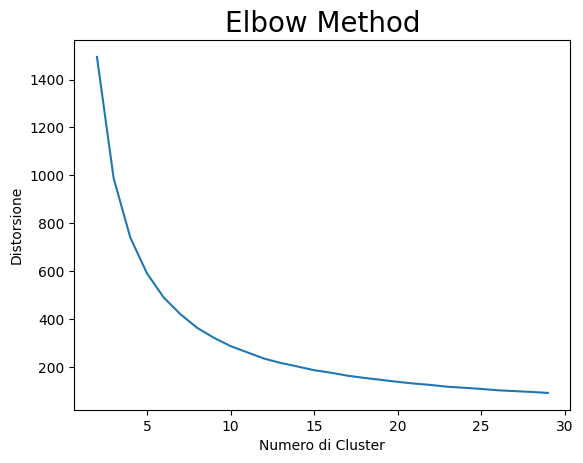

In [60]:
distorsions = []
for i in range(2, 30):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    cluster_labels = km.fit_predict(users)
    distorsions .append(km.inertia_ / i)
    print("Iteration number ", i)
plt.plot(range(2, 30), distorsions )
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Numero di Cluster')
plt.ylabel('Distorsione')
plt.show()

In [61]:
derivata_seconda = np.diff(distorsions, 2)
best_k = np.argmin(derivata_seconda) + 2
print(best_k)

15


## Configurazione ottima K-Means <a class="anchor"  id="conf_ottima_k_means"></a>

In [62]:
km = KMeans(n_clusters = best_k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(users)

KMeans(n_clusters=15, n_init=10, random_state=0)